# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [76]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [77]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [78]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [79]:
batch[0], batch[0][1].shape

([1,
  array([ 0.00177672,  0.18013244, -0.04925254, -0.34237579]),
  1.0,
  False,
  {}],
 (4,))

In [80]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [81]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
3.151448306139565 -2.503932349858582


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [82]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards') # env rewards
    rewards2 = tf.placeholder(tf.float32, [None], name='rewards2') # actions logits rewards
    rewards3 = tf.placeholder(tf.float32, [None], name='rewards3') # actions labels rewards
    return states, actions, rewards, rewards2, rewards3

In [83]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [84]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [85]:
# Policy learning: past/taken action
# Adverserial/reward learning: current reward optimization
# Q learning: future rewards optimization
def model_loss(action_size, hidden_size, # model init
               states, actions, rewards, rewards2, rewards3): # model input for G & D 
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                       labels=actions_labels))        
    
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    actions_probs = tf.nn.softmax(actions_logits)
    Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    rewards2_logits = tf.nn.sigmoid(Qs2_logits) # total_rewards2
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                    labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                     labels=tf.reshape(rewards2[1:], shape=[-1, 1])))
    
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rewards3_logits = tf.nn.sigmoid(Qs3_logits) # total_rewards3
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
                                                                    labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
                                                                     labels=tf.reshape(rewards3[1:], shape=[-1, 1])))
    
    # Returning/outputing actions, sum of rewards, rewards, and loss
    return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss

In [86]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        gd_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=g_vars)

    return g_opt, d_opt, gd_opt

In [88]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards, self.rewards2, self.rewards3 = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.rewards2_logits, self.rewards3_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init 
            actions=self.actions, states=self.states, # model input
            rewards=self.rewards, rewards2=self.rewards2, rewards3=self.rewards3) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.gd_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, 
                                                        learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [89]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)
print(np.max(actions))
print(np.min(actions))

state size:(1000, 4) actions:(1000,)
2
1
0


In [90]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [91]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [92]:
env.reset()

array([-0.02513522, -0.0126087 , -0.01629541, -0.04192718])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [93]:
state, reward, action

(array([ 0.03992312,  0.37256458,  0.01733875, -0.53253701]), 1.0, 1)

In [95]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            action *= 1 - float(done) # last action is always 0
            batch.append([state, action])
            state = next_state
            total_reward += reward
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states,
                                                                     model.actions: actions})
        # loss = sess.run(model.g_loss, feed_dict = {model.states: states,
        #                                            model.actions: actions})
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, loss])
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-g.ckpt')

Episode: 0 Total reward: 67.0 Batch loss: 0.678190410
Episode: 1 Total reward: 114.0 Batch loss: 0.671314836
Episode: 2 Total reward: 68.0 Batch loss: 0.662405670
Episode: 3 Total reward: 108.0 Batch loss: 0.660720944
Episode: 4 Total reward: 115.0 Batch loss: 0.675938964
Episode: 5 Total reward: 124.0 Batch loss: 0.645228744
Episode: 6 Total reward: 133.0 Batch loss: 0.642548084
Episode: 7 Total reward: 77.0 Batch loss: 0.632943869
Episode: 8 Total reward: 75.0 Batch loss: 0.628969491
Episode: 9 Total reward: 153.0 Batch loss: 0.624553084
Episode: 10 Total reward: 96.0 Batch loss: 0.645172238
Episode: 11 Total reward: 169.0 Batch loss: 0.627726853
Episode: 12 Total reward: 100.0 Batch loss: 0.605705380
Episode: 13 Total reward: 178.0 Batch loss: 0.613334656
Episode: 14 Total reward: 60.0 Batch loss: 0.596488655
Episode: 15 Total reward: 85.0 Batch loss: 0.611584663
Episode: 16 Total reward: 200.0 Batch loss: 0.578311384
Episode: 17 Total reward: 110.0 Batch loss: 0.570101023
Episode: 

Episode: 161 Total reward: 12.0 Batch loss: 0.236666083
Episode: 162 Total reward: 19.0 Batch loss: 0.147642791
Episode: 163 Total reward: 13.0 Batch loss: 0.065382704
Episode: 164 Total reward: 16.0 Batch loss: 0.226850986
Episode: 165 Total reward: 15.0 Batch loss: 0.065284982
Episode: 166 Total reward: 14.0 Batch loss: 0.249012113
Episode: 167 Total reward: 13.0 Batch loss: 0.076934114
Episode: 168 Total reward: 14.0 Batch loss: 0.275676221
Episode: 169 Total reward: 16.0 Batch loss: 0.207806349
Episode: 170 Total reward: 17.0 Batch loss: 0.049558379
Episode: 171 Total reward: 17.0 Batch loss: 0.056477498
Episode: 172 Total reward: 13.0 Batch loss: 0.067948505
Episode: 173 Total reward: 14.0 Batch loss: 0.212959632
Episode: 174 Total reward: 19.0 Batch loss: 0.095872238
Episode: 175 Total reward: 15.0 Batch loss: 0.052034054
Episode: 176 Total reward: 14.0 Batch loss: 0.198181704
Episode: 177 Total reward: 17.0 Batch loss: 0.061733127
Episode: 178 Total reward: 17.0 Batch loss: 0.04

Episode: 320 Total reward: 10.0 Batch loss: 0.227421194
Episode: 321 Total reward: 10.0 Batch loss: 0.256637216
Episode: 322 Total reward: 10.0 Batch loss: 0.201506972
Episode: 323 Total reward: 12.0 Batch loss: 0.318427652
Episode: 324 Total reward: 9.0 Batch loss: 0.025758781
Episode: 325 Total reward: 10.0 Batch loss: 0.022360433
Episode: 326 Total reward: 10.0 Batch loss: 0.008972807
Episode: 327 Total reward: 10.0 Batch loss: 0.005805988
Episode: 328 Total reward: 8.0 Batch loss: 0.000302831
Episode: 329 Total reward: 10.0 Batch loss: 0.000664431
Episode: 330 Total reward: 9.0 Batch loss: 0.000092485
Episode: 331 Total reward: 11.0 Batch loss: 0.000184446
Episode: 332 Total reward: 10.0 Batch loss: 0.000127847
Episode: 333 Total reward: 9.0 Batch loss: 0.000016901
Episode: 334 Total reward: 10.0 Batch loss: 0.000070710
Episode: 335 Total reward: 9.0 Batch loss: 0.000005801
Episode: 336 Total reward: 10.0 Batch loss: 0.000018608
Episode: 337 Total reward: 9.0 Batch loss: 0.00000574

Episode: 468 Total reward: 10.0 Batch loss: 0.000001788
Episode: 469 Total reward: 8.0 Batch loss: 0.000000402
Episode: 470 Total reward: 10.0 Batch loss: 0.000001824
Episode: 471 Total reward: 9.0 Batch loss: 0.000000172
Episode: 472 Total reward: 10.0 Batch loss: 0.000000882
Episode: 473 Total reward: 10.0 Batch loss: 0.000000679
Episode: 474 Total reward: 9.0 Batch loss: 0.000000795
Episode: 475 Total reward: 10.0 Batch loss: 0.000001359
Episode: 476 Total reward: 9.0 Batch loss: 0.000001258
Episode: 477 Total reward: 9.0 Batch loss: 0.000000649
Episode: 478 Total reward: 10.0 Batch loss: 0.000001025
Episode: 479 Total reward: 8.0 Batch loss: 0.000000268
Episode: 480 Total reward: 9.0 Batch loss: 0.000000781
Episode: 481 Total reward: 10.0 Batch loss: 0.000000489
Episode: 482 Total reward: 9.0 Batch loss: 0.000000636
Episode: 483 Total reward: 9.0 Batch loss: 0.000000411
Episode: 484 Total reward: 9.0 Batch loss: 0.000000570
Episode: 485 Total reward: 9.0 Batch loss: 0.000000358
Epi

Episode: 638 Total reward: 9.0 Batch loss: 0.000000252
Episode: 639 Total reward: 9.0 Batch loss: 0.000000212
Episode: 640 Total reward: 8.0 Batch loss: 0.000000224
Episode: 641 Total reward: 10.0 Batch loss: 0.000000727
Episode: 642 Total reward: 9.0 Batch loss: 0.000000450
Episode: 643 Total reward: 9.0 Batch loss: 0.000000676
Episode: 644 Total reward: 9.0 Batch loss: 0.000000702
Episode: 645 Total reward: 10.0 Batch loss: 0.000001419
Episode: 646 Total reward: 9.0 Batch loss: 0.000000278
Episode: 647 Total reward: 11.0 Batch loss: 0.000002948
Episode: 648 Total reward: 8.0 Batch loss: 0.000000194
Episode: 649 Total reward: 10.0 Batch loss: 0.000000489
Episode: 650 Total reward: 9.0 Batch loss: 0.000000556
Episode: 651 Total reward: 10.0 Batch loss: 0.000001168
Episode: 652 Total reward: 8.0 Batch loss: 0.000000507
Episode: 653 Total reward: 9.0 Batch loss: 0.000000609
Episode: 654 Total reward: 10.0 Batch loss: 0.000001466
Episode: 655 Total reward: 9.0 Batch loss: 0.000000543
Epis

Episode: 788 Total reward: 10.0 Batch loss: 0.000000989
Episode: 789 Total reward: 8.0 Batch loss: 0.000000194
Episode: 790 Total reward: 10.0 Batch loss: 0.000001800
Episode: 791 Total reward: 9.0 Batch loss: 0.000001073
Episode: 792 Total reward: 9.0 Batch loss: 0.000000159
Episode: 793 Total reward: 9.0 Batch loss: 0.000000623
Episode: 794 Total reward: 10.0 Batch loss: 0.000000751
Episode: 795 Total reward: 10.0 Batch loss: 0.000000906
Episode: 796 Total reward: 8.0 Batch loss: 0.000000238
Episode: 797 Total reward: 10.0 Batch loss: 0.000001574
Episode: 798 Total reward: 9.0 Batch loss: 0.000000397
Episode: 799 Total reward: 10.0 Batch loss: 0.000000787
Episode: 800 Total reward: 9.0 Batch loss: 0.000000887
Episode: 801 Total reward: 10.0 Batch loss: 0.000001156
Episode: 802 Total reward: 10.0 Batch loss: 0.000001097
Episode: 803 Total reward: 8.0 Batch loss: 0.000000238
Episode: 804 Total reward: 10.0 Batch loss: 0.000001109
Episode: 805 Total reward: 8.0 Batch loss: 0.000000209
E

Episode: 938 Total reward: 8.0 Batch loss: 0.000000373
Episode: 939 Total reward: 10.0 Batch loss: 0.000000715
Episode: 940 Total reward: 10.0 Batch loss: 0.000000989
Episode: 941 Total reward: 9.0 Batch loss: 0.000000291
Episode: 942 Total reward: 10.0 Batch loss: 0.000001454
Episode: 943 Total reward: 9.0 Batch loss: 0.000001536
Episode: 944 Total reward: 9.0 Batch loss: 0.000000225
Episode: 945 Total reward: 9.0 Batch loss: 0.000000755
Episode: 946 Total reward: 10.0 Batch loss: 0.000001407
Episode: 947 Total reward: 8.0 Batch loss: 0.000000596
Episode: 948 Total reward: 8.0 Batch loss: 0.000000298
Episode: 949 Total reward: 9.0 Batch loss: 0.000000689
Episode: 950 Total reward: 10.0 Batch loss: 0.000001299
Episode: 951 Total reward: 10.0 Batch loss: 0.000000525
Episode: 952 Total reward: 11.0 Batch loss: 0.000001886
Episode: 953 Total reward: 9.0 Batch loss: 0.000000755
Episode: 954 Total reward: 8.0 Batch loss: 0.000000283
Episode: 955 Total reward: 10.0 Batch loss: 0.000002611
Ep

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

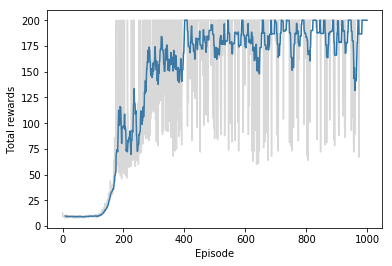

In [41]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

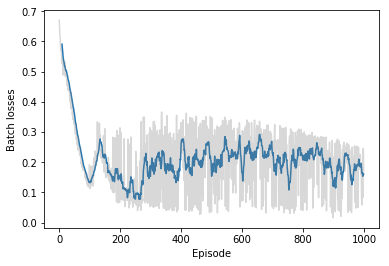

In [42]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [75]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

# Now train with experiences
saver = tf.train.Saver()

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-gd.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-gd.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


NotFoundError: Key beta1_power_2 not found in checkpoint
	 [[Node: save_8/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_8/Const_0_0, save_8/RestoreV2/tensor_names, save_8/RestoreV2/shape_and_slices)]]

Caused by op 'save_8/RestoreV2', defined at:
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-69b02ec275a4>", line 18, in <module>
    saver = tf.train.Saver()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1311, in __init__
    self.build()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1320, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1357, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 809, in _build_internal
    restore_sequentially, reshape)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 448, in _AddRestoreOps
    restore_sequentially)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 860, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1458, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key beta1_power_2 not found in checkpoint
	 [[Node: save_8/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_8/Const_0_0, save_8/RestoreV2/tensor_names, save_8/RestoreV2/shape_and_slices)]]


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.

In [44]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [63]:
# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, gloss_list, dloss_list = [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    train_episodes = 100
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits, reward2, reward3 = sess.run([model.actions_logits, 
                                                        model.rewards2_logits, 
                                                        model.rewards3_logits],
                                                       feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                                  model.actions: np.array([action])})
                                                                  #model.actions: np.reshape(action, [-1])})
            #print(reward2[0, 0], reward3.reshape(-1))
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
        g_loss, d_loss, _ = sess.run([model.g_loss, model.d_loss, model.d_opt], 
                                     feed_dict = {model.states: states,
                                                  model.actions: actions, 
                                                  model.rewards:rewards, 
                                                  model.rewards2:rewards2, 
                                                  model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        gloss_list.append([ep, g_loss])
        dloss_list.append([ep, d_loss])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-gd.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model-gd.ckpt


TypeError: Cannot interpret feed_dict key as Tensor: The name 'save_13/Const:0' refers to a Tensor which does not exist. The operation, 'save_13/Const', does not exist in the graph.

Text(0,0.5,'Total env rewards')

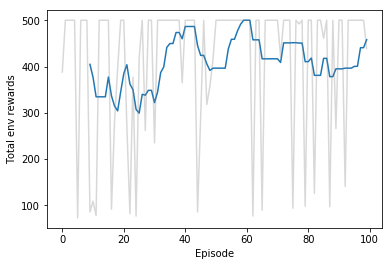

In [47]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total env rewards')

Text(0,0.5,'Total actions logits rewards')

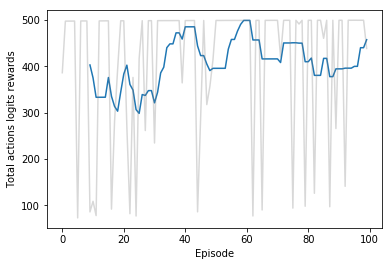

In [50]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions logits rewards')

Text(0,0.5,'Total actions labels/onehot rewards')

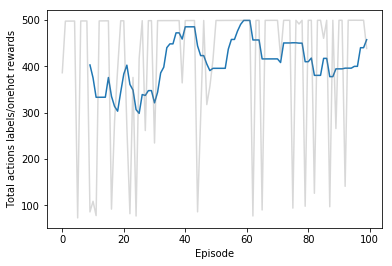

In [49]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions labels/onehot rewards')

Text(0,0.5,'Batch loss')

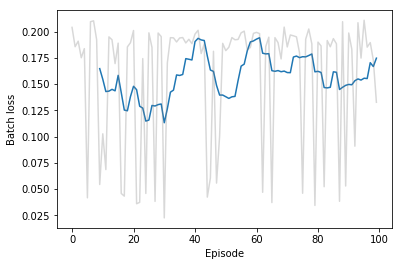

In [52]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch loss')

Text(0,0.5,'Batch loss')

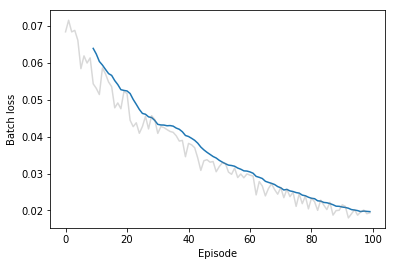

In [53]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch loss')

In [ ]:
# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, gloss_list, dloss_list = [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    train_episodes = 100
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits, reward2, reward3 = sess.run([model.actions_logits, 
                                                        model.rewards2_logits, 
                                                        model.rewards3_logits],
                                                       feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                                  model.actions: np.array([action])})
                                                                  #model.actions: np.reshape(action, [-1])})
            #print(reward2[0, 0], reward3.reshape(-1))
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
        g_loss, d_loss, _ = sess.run([model.g_loss, model.d_loss, model.d_opt], 
                                     feed_dict = {model.states: states,
                                                  model.actions: actions, 
                                                  model.rewards:rewards, 
                                                  model.rewards2:rewards2, 
                                                  model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        gloss_list.append([ep, g_loss])
        dloss_list.append([ep, d_loss])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-g-d-g.ckpt')